# Welcome

The **Py**thon packages **f**or **A**coustics **R**esearch (pyfar) contain classes and function for the acquisition, inspection, and processing of audio signals. This is the pyfar demo notebook and a good place for getting started. In this notebook, you will see examples of the most important pyfar functionalty. 

**Note:** This is not a substitute for the pyfar documentaion at **insert_url**.

## Contents

[Signals](#signals)
- [FFT normalization](#fft_normalization)
- [Accessing Signal data](#accessing_signal_data)
- [Iterating Signals](#accessing_signal_data)
- [Signal meta data](#signal_meta_data)
- [Arithmetic operations](#arithmetic_operations)
- [Plotting](#plotting)
    - [Line plots](#line_plots)
    - [Plane plots](#plane_plots) TODO

[Coordinates](#coordinates)
- [Entering coordinate points](#coordinates_enter)
- [Retrieving coordinate points](#coordinates_retrieve)
- [Rotating coordinate points](#coordinates_rotate)

[Orientations](#orientations)
- [Entering orientations](#entering_orientations)
- [Retrieving orientations](#retrieving_orientations)
- [Rotating orientations](#rotating_orientations)

[DSP](#dsp)
- [Filtering](#filtering)

[In'n'out](#in_and_out)
- [Read and write workspace](#io_workspaces) TODO
- [Read and write wav files](#io_wav_files)
- [Read SOFA files](#io_sofa)


Lets start with importing pyfar and numpy:

In [6]:
# import packages
import pyfar
from pyfar import Signal                     # managing audio signals
from pyfar.coordinates import Coordinates    # managing satial sampling points
from pyfar.orientations import Orientations  # managing orientation vectors
from pyfar.spatial import samplings          # creating predefined spatial sampling grids
import pyfar.plot as plot                    # beatiful plots
import pyfar.dsp.filter as filt              # most common filters in Acoustics
import numpy as np                           # you gotta love numpy, but pandas are cuter

# Signals<a class="anchor" id="signals"></a>

Audio signals are the basis of pyfar. They are stored in objects of the `Signal` class along with information about the sampling rate, the domain (`time`, or `freq`), the FFT type and an optional comment. Lets go ahead and create a single channel signal:

In [7]:
# create a dirac signal with a sampling rate of 44.1 kHz
fs = 44100
x = np.zeros(44100)
x[0] = 1
x_energy = Signal(x, fs)

# show information
x_energy

time domain energy Signal:
(1,) channels with 44100 samples @ 44100 Hz sampling rate and none FFT normalization

## FFT Normalization<a class="anchor" id="fft_normalization"></a>

The spectral content of signals can be inspected in different ways, referred to as FFT normalizations. Pyfar knows the four normalizations `'amplitude'`, `'rms'`, `'power'`, and `'psd'` (cf. [Ahrens, et al. 2020](http://www.aes.org/e-lib/browse.cfm?elib=20838)). Two additional normalizations are available. `'unitary'` only applies the weighting for the single sided spectrum (Eq. 8 in Ahrens et al. 2020). `'none'` applies no normalization, which is usefull for signals with finite energy such as impulse responses. The default normalization is `'none'`. Let's create a signal with a different normalization

In [8]:
x = np.sin(2 * np.pi * 1000 * np.arange(441) / fs)
x_power = Signal(x, fs, fft_norm='rms')

The normalization can be changed. In this case the spectral data of the signal is converted internally using `pyfar.fft.normalization()`

In [9]:
x_power.fft_norm = 'amplitude'
x_power.fft_norm

'amplitude'

## Accessing Signal data<a class="accessing_signal_data" id="signals"></a>

You can access the data, i.e., the audio signal, inside a Signal object in the time and frequency domain by simply using

In [10]:
time_data = x_power.time
freq_data = x_power.freq

Two things are important here:

1. `time_data` is mutable! That means `x.power.time` changes if you change `time_data`. If this is not what you want use `time_data = x_power.time.copy()` instead.

2. The frequency data of signals depends on the Signal's `fft_norm`. Internally, the data are stored either in the `'time'` or `'freq'` domain. It is tranformed every time you access it without changing the internal state. In some cases it might be more efficient to store the data in a specif domain to avoid additional Fourier Transforms. Lets check out the current domain

In [11]:
x_power.domain

'freq'

and change it

In [12]:
x_power.domain = 'freq'
x_power.domain

'freq'

`Signals` and some other pyfar objects support slicing. Let's illustrate that for a two channel signal

In [13]:
# generate two channel time data
time = np.zeros((2, 4))
time[0,0] = 1   # first sample of first channel
time[1,0] = 2   # first sample of second channel

x_two_channels = Signal(time, 44100)
x_first_channel = x_two_channels[0]

`x_first_channel` is a `Signal` object itself, which contains the first channel of `x_two_channels`:

In [14]:
x_first_channel.time

array([[1., 0., 0., 0.]])

A third option to access `Signals` is to copy it

In [15]:
x_copy = x_two_channels.copy()

It is important to note that his return an independent copy of `x_two_channels`. Note that the operation `x_copy = x_two_channles` should be avoided. In this case changes to `x_copy` will also change `x_two_channels`. The `copy()` operation is available for all pyfar object.

## Iterating Signals<a class="signal_meta_data" id="accessing_signal_data"></a>

It is the aim of pyfar that all operations work on N-dimensional `signals`. Nevertheless, you can also iterate `signals` if you need to apply operations depending on the channel. Lets look at a simple example

In [16]:
signal = Signal([[0, 0, 0], [1, 1, 1]], 44100)  # 2-channel signal

# iterate the signal
for n, channel in enumerate(signal):
    print(f"Channel: {n}, time data: {channel.time}")
    # do something channel dependent
    channel.time = channel.time + n
    # write changes to the signal
    signal[n] = channel

# q.e.d.
print(f"\nNew signal time data:\n{signal.time}")

Channel: 0, time data: [[0. 0. 0.]]
Channel: 1, time data: [[1. 1. 1.]]

New signal time data:
[[0. 0. 0.]
 [2. 2. 2.]]


`Signal` uses the standard `numpy` iterator which always iterates the first dimension. In case of a 2-D array as in the example above these are the channels.

## Signal meta data<a class="signal_meta_data" id="signals"></a>

The `Signal` object also holds usefull metadata. The most important might be:

- `Signal.n_samples`: The number of samples in each channel (`Signal.time.shape[-1]`)
- `Signal.n_bins`: The number of frequencies in each channel (`Signal.time.shape[-1]`)
- `Signal.times`: The sampling times of `Signal.time` in seconds
- `Signal.freqs`: The frequencies of `Signal.freq` in Hz


## Arithmetic operations<a class="arithmetic_operations" id="signals"></a>

Arithmetic operations on audio signals are comman, `pyfar.signal` contains the functions `add`, `subtract`, `multiply`, `divide`, and `power` for this purpose. The operations can be performed in the time and frequency domain, and work on arbitrary numbers of Signals and array likes. Lets check out simple examples

In [17]:
# add two signals energy signals
x_sum = pyfar.signal.add((x_energy, x_energy), 'time')
x_sum.time



array([[2., 0., 0., ..., 0., 0., 0.]])

In this case, `x_sum` is also an energy Signal. However, if any power Signal is involved in an arithmetic operation, the result will be a power Signal. The FFT normalization of the result is always obtained from the first Signal in the input data. You can also apply arithmetic operatoins on a `Signal` and a vector. Under the hood, the operations use numpys powerfull [array broadcasting](https://numpy.org/doc/stable/user/basics.broadcasting.html?highlight=broadcast#module-numpy.doc.broadcasting). This means you can add scalars, vectors, and matrixes to a signal, if they broadcast together. Lets have a frequency domain examlpe for this

In [18]:
x_sum = pyfar.signal.add((x_energy, 1), 'freq')
x_sum.time

array([[2., 0., 0., ..., 0., 0., 0.]])

For convenience, the Python operators `+`, `-`, `*`, `/`, and `**` are overloaded with the **frequncy domain** arithmetic functions. Thus, the example above can also be shortened to

In [19]:
x_sum = x_energy + 1
x_sum.time

array([[2., 0., 0., ..., 0., 0., 0.]])

But keep in mind, that you have to use `pyfar.signal.add((...), 'time')` for time domain operations.

# Plotting<a class="anchor" id="plotting"></a>

Inspecting acoustic signals is one of the most common tasks in our field, which can be done with `pyfar.plot`

## Line Plots<a class="anchor" id="line_plots"></a>

`pyfar.plot.line` can be used for simple plots of the time and spectral data. Lets check this out with one example

<AxesSubplot:xlabel='Frequency in Hz', ylabel='Magnitude in dB'>

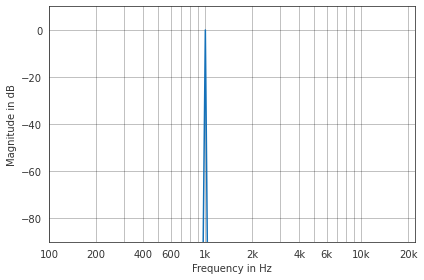

In [20]:
plot.line.freq(x_power)

We set the FFT normalization to 'amplitude' before. The plot thus shows the Amplitude of our sine wave contained in `x_power`. We can also look at the RMS value

<AxesSubplot:xlabel='Frequency in Hz', ylabel='Magnitude in dB'>

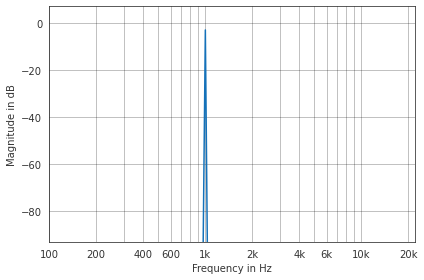

In [21]:
x_power.fft_norm = 'rms'
plot.line.freq(x_power)

It is worth noting that the 'time' representation of a `Signal` is not affected by the FFT normalization, i.e., the time domain amplitude remains 1. BTW Mr. fancy pants, we also have a build in dark theme

<AxesSubplot:xlabel='Time in ms', ylabel='Amplitude'>

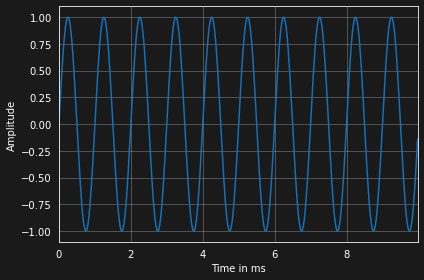

In [22]:
plot.line.time(x_power, style='dark')

## Plane plots<a class="anchor" id="plane_plots"></a> [TODO]


**808 - Found but not ready yet**


# Coordinates<a class="anchor" id="coordinates"></a>

The `Coordinates()` class is designed for storing, manipulating, and acessing coordinate points in a large variety of different coordinate conventions. Examples for data that can be stored are microphone positions of a spherical microphone array and loudspeaker positions of a sound field synthesis system. Lets create and empty `Coordinates` object and look at the implemented conventions first:

In [23]:
c = Coordinates()
c.systems()

- - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - -
domain: cart, convention: right, unit: [met]

Right handed cartesian coordinate system.

Coordinates:
points_1: x  [meters]
points_2: y  [meters]
points_3: z  [meters]

Right handed cartesian coordinate system with x,y, and z in meters.


- - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - -
domain: sph, convention: top_colat, unit: [rad, deg]

Spherical coordinate system with North and South Pole.

Coordinates:
points_1: azimuth  [radians, degrees]
points_2: colatitude  [radians, degrees]
points_3: radius  [meters, meters]

The azimuth denotes the counter clockwise angle in the x/y-plane with 0 pointing in positive x-direction and pi/2 in positive y-direction. The colatitude denotes the angle downwards from the z-axis with 0 pointing in positve z-direction and pi in negative z-direction. The azimuth and colatitude can be in radians or degrees, the radius is always in meters.


- - - - - - - - - - - - - -

## Entering coordinate points<a class="anchor" id="coordinates_enter"></a>

Coordinate points can be entered manually or by using one of the available sampling schemes contained in `pyfar.spatial.samplings`. We will do the latter using an equal angle sampling and look at the information provided by the coordinates object:

1D Coordinates object with 308 points of cshape (308,)
domain: sph, convention: top_colat, unit: deg
coordinates: azimuth in degrees, colatitude in degrees, radius in meters
Does not contain sampling weights
Comment: equal angle spherical sampling grid


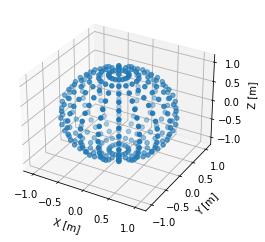

In [24]:
c = samplings.sph_equal_angle((20, 10))
# show general information
print(c)
# plot the sampling points
c.show()

Inside the `Coordinates` object, the points are stored in an N-dimensional array of size `[..., 3]` where the last dimension in this case holds the azimuth, colatitude, and radius. Information about coordinate array can be obtained by `c.cshape`, `c.csize`, and `c.cdim`. These properties are similar to numpy's `shape`, `size`, and `dim` but ignore the last dimension, which is always 3.

## Retrieving coordinate points<a class="anchor" id="coordinates_retrieve"></a>

There are different ways to retrieve points from a `Coordinates` object. All points can be obtained in cartesian, spherical, and cylindrical coordinates using the getter functions `c.get_cart()`, `c.get_sph()` and `c.get_cyl()`, e.g.:

In [25]:
cartesian_coordinates = c.get_cart()

Different methods are available for obtaining a specific subset of coordinates. For example the nearest point(s) can be obtained by

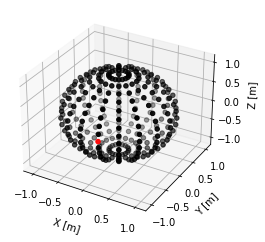

In [26]:
c_out = c.get_nearest_k(
    270, 90, 1, k=1, domain='sph', convention='top_colat', unit='deg', show=True)

To obtain all points within a specified eucledian distance or arc distance, you can use `c.get_nearest_cart()` and `c.get_nearest_sph()`. To obtain more complicated subsets of any coordinate, e.g., the horizontal plane with `colatitude=90` degree, you can use slicing

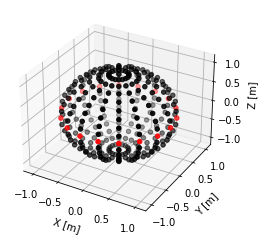

In [27]:
mask_hor = c.get_slice('colatitude', 'deg', 90, show=True)

## Rotating coordinates<a class="anchor" id="coordinates_rotate"></a>

You can apply rotations using quaternions, rotation vectors/matrixes and euler angles with  `c.rotate()`, which is a wrapper for `scipy.spatial.transform.Rotation`. For example rotating around the y-axis by 45 degrees can be done with

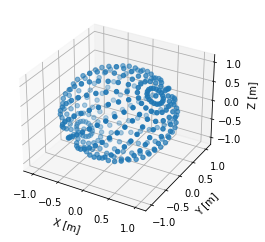

In [28]:
c.rotate('y', 45)
c.show()

Note that this changes the points inside the `Coordinates` object, which means that you have to be carefull not to apply the rotation multiple times, i.e., when evaluationg cells during debugging.

# Orientations<a class="anchor" id="orientations"></a>

The `Orientations()` class is designed storing, manipulating, and accessing orientation vectors. Examples for this are the orientations of directional loudspeakers when measuring room impulse responses or the head orientation belonging to binaural impulse responses. It is good to know that `Orientations` is inherited from `scipy.spatial.transform.Rotation` and that all methods of this class can also be used with `Orientations`.

## Entering orientations<a class="anchor" id="entering_orientations"></a>

Lets go ahead and create an object and show the result

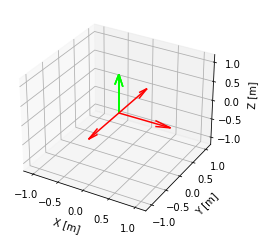

In [29]:
views = [[0,  1, 0],
         [1,  0, 0],
         [0, -1, 0]]
up = [0, 0, 1]
orientations = Orientations.from_view_up(views, up)
orientations.show(show_rights=False)


It is also possible to enter `Orientations` from `Coordinates` object or mixtures of `Coordinates` objects and array likes. This is equivalent to the example above

In [30]:
views_c = Coordinates([90, 0, 270], 0, 1,
                      domain='sph', convention='top_elev', unit='deg')

orientations = Orientations.from_view_up(views_c, up)

## Retrieving orientations<a class="anchor" id="retrieving_orientations"></a>

Orientaions can be retrieved as view, up, and right-vectors and in any format supported by `scipy.spatial.transform.Rotation`. They can also easily converted into any coordinate convention supported by pyfar by putting them into a `Coordinates` object. Lets only check out one way for now 

In [31]:
views, ups, right, = orientations.as_view_up_right()

In this case the output is identical to the input. This would not be the case if for exaple using `view = [2, 0, 0]` in which case the output would be the unit vector `[1, 0, 0]`.

## Rotating orientations<a class="anchor" id="rotating_orientations"></a>

Rotations can be done using the methods inherited from `scipy.spatial.transform.Rotation`. You can for example rotate around the y-axis this way

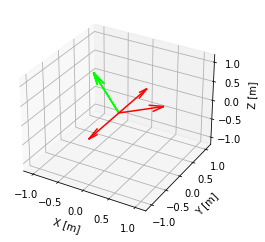

In [32]:
rotation = Orientations.from_euler('y', 30, degrees=True)
orientations_rot = orientations * rotation
orientations_rot.show(show_rights=False)

# DSP<a class="in_and_out" id="dsp"></a>

`pyfar.dsp` offers lots of usefull functions to manipulate the data inside `Signal` objects. Lets take a tour

## Filtering<a class="in_and_out" id="filtering"></a>

`pyfar.dsp.filter` contains wrappers for the most common filters of `scipy.signal`
- Butterworth,
- Chebychev type I and II,
- Elliptic (Cauer), and
- Bessel/Thomson

and other usefull filter functions
- Linkwitz-Riley Crossover networks
- Fractional octave filters [TODO]
- Auditory filters [TODO]
- Parametric equalizers
- Shelve filters
- Constant slope filters [TODO]

They can all be assessed in a similar manner, like this one


<AxesSubplot:xlabel='Frequency in Hz', ylabel='Magnitude in dB'>

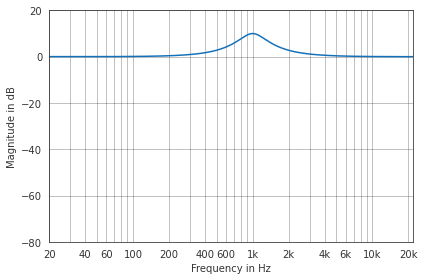

In [33]:
x_filter = filt.peq(x_energy, center_frequency=1e3, gain=10, quality=2)
plot.line.freq(x_filter)

# In'n'out<a class="in_and_out" id="signals"></a>

Now that you know what pyfar is about, let's see how you can save your work and read comman data types.

## Read and write workspace<a class="in_and_out" id="#io_workspaces"></a> [ToDo]

**808 - Found but not ready yet**

## Read and write wav-files<a class="in_and_out" id="wav_files"></a>

Wav-files are commonly used in the audio community to store and exchange data. You can read them with

`signal = pyfar.io.read_wav(filename)`

and write them with

`pyfar.io.write_wav(signal, filename, overwrite=True)`.

You can write any `signal` to a wav-file also if they have values > 1. Multidimensional `signals` will be reshaped to 2D arrays before writing.

## Read SOFA files<a class="in_and_out" id="#io_sofa"></a>

[SOFA files](https://www.sofaconventions.org) can be used to store spatially distributet acoustical data sets. Examples for this are room acoustic measurements at different positions in a room or a set of head-related transfer functions for different source postitions. SOFA files can quickly be read by

`signal, source, receiver =  pfar.io.read_sofa(filename)`

which returns the audio data as a `Signal` and the source and receiver coordinates as a `Coordinates` object.

`read_sofa` is a wrapper for `python_sofa`, which can be used to write SOFA files or access more meta data contained in SOFA files.

# My Tests

In [1]:
import pyfar as pf 

pf.dsp.dummyfunction(10)


10


In [9]:
import numpy as np
import pyfar as pf

fs = 44100

x1 = np.array([[1, 2, 3, 4],
              [2, 3, 4, 5],
              [6, 7, 8, 9]])

x2 = np.array([1,2,3,4])

test_signal = pf.Signal(x1, fs)

pf.dsp.normalize(test_signal, operation = 'max', channelwise = 'each', value = 10)

array([[ 2.5       ,  5.        ,  7.5       , 10.        ],
       [ 4.        ,  6.        ,  8.        , 10.        ],
       [ 6.66666667,  7.77777778,  8.88888889, 10.        ]])